In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
def read_text(filename):
  file=open(filename, mode='rt', encoding='utf-8')
  text = file.read()
  file.close()
  return text

In [12]:
#split the text into sentences
def to_lines(text):
  sents = text.strip().split('\n')
  sents =[i.split('\t') for i in sents]
  #print(sents[:2])
  return sents

In [19]:
data =read_text("deu.txt")
deu_eng=to_lines(data)
deu_eng= array(deu_eng)

In [20]:
#To reduce the training time of the model I will be using only 50000 snetence pairs for training
deu_eng = deu_eng[:50000,:2]

TEXT PREPROCESSING 

The data we work with is more often than not structured so there are certain thing we need to take care of before jumping to model building part

In [21]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ['No one encouraged her.', 'Niemand ermutigte sie.'],
       ['No one has that right.', 'Niemand hat dieses Recht.'],
       ['No one has that right.', 'Dieses Recht hat niemand.']],
      dtype='<U537')

In [22]:
# get rid of punctuation marks and also converting the text into lower case
deu_eng[:,0] = [s.translate(str.maketrans('', '',string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('','', string.punctuation)) for s in deu_eng[:,1]]
deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['No one encouraged her', 'Niemand ermutigte sie'],
       ['No one has that right', 'Niemand hat dieses Recht'],
       ['No one has that right', 'Dieses Recht hat niemand']],
      dtype='<U537')

In [23]:
for i in range(len(deu_eng)):
  deu_eng[i,0] = deu_eng[i,0].lower()
  deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng  

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['no one encouraged her', 'niemand ermutigte sie'],
       ['no one has that right', 'niemand hat dieses recht'],
       ['no one has that right', 'dieses recht hat niemand']],
      dtype='<U537')

TEXT TO SEQUENCE CONVERSION

A sequence to sequence model requires that we convert both the input and the output sentences into integer sequences of fixed length .


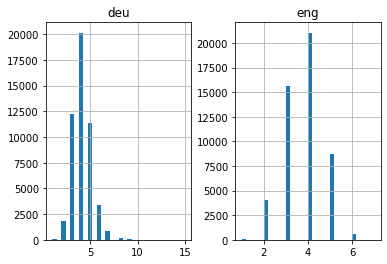

In [25]:
eng_l =[]
deu_l = []

#populate lists with sentence lengths
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))

length_df=pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins=30)
plt.show()   

Preparing token for both germn and english language

In [26]:
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [29]:
eng_tokenizer = tokenization(deu_eng[:,0])
deu_tokenizer = tokenization(deu_eng[:,1])
eng_vocab_size= len(eng_tokenizer.word_index) +1
eng_length =8

deu_vocab_size = len(deu_tokenizer.word_index)+1
deu_length=8
print(eng_vocab_size)
deu_vocab_size

6243


10329

In [36]:
# padding to maximize sentence length as mentioned above

def encode_sequences(tokenizer, length , lines):
  seq= tokenizer.texts_to_sequences(lines)
  #pad sequences with 0 value
  seq = pad_sequences(seq, maxlen=length , padding='post')
  return seq

Splitting the data into training and testing for evaluation

In [38]:
from sklearn.model_selection import train_test_split
train ,test = train_test_split(deu_eng, test_size=0.2, random_state=12)

It's time to encode the sentences . We will encode German sentences as the input sequences and English sentences as the target sequences. This has to be done for both training and testing datasets

In [40]:
trainX = encode_sequences(deu_tokenizer, deu_length,train[:,1])
trainY= encode_sequences(eng_tokenizer, eng_length , train[:,0])

testX = encode_sequences(deu_tokenizer, deu_length, test[:,1])
testY = encode_sequences(eng_tokenizer, eng_length
                         , test[:,0])


Now comes the exiting part!

We'll start off by defining our Seq2seq model architecture:

->For the encoder, we will use an embedding layer and an LSTM layer

->For the decoder, we will use another LSTM layer and dense layer.

In [41]:
#build NMT model
def defnie_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model =Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model


In [42]:
model = defnie_model(deu_vocab_size, eng_vocab_size,deu_length , eng_length , 512)

In [44]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')


The loss function, this is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. 
## One hot encoding the target sequences using such as huge vocabulary might consume our system's entire memory.


In [45]:
filename = 'model.h1.24_jan_20'
checkpoint= ModelCheckpoint(filename, monitor='val_loss',verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0],trainY.shape[1],1), epochs=30, batch_size=512, validation_split=0.2, callbacks=[checkpoint],verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.4031
Epoch 00001: val_loss improved from inf to 2.84726, saving model to model.h1.24_jan_20
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.h1.24_jan_20/assets
63/63 [==============================] - 305s 5s/step - loss: 3.4031 - val_loss: 2.8473
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.7767
Epoch 00002: val_loss improved from 2.84726 to 2.73137, saving model to model.h1.24_jan_20
INFO:tensorflow:Assets written to: model.h1.24_jan_20/assets
63/63 [==============================] - 302s 5s/step - loss: 2.7767 - val_loss: 2.7314
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.6235
Epoch 00003: val_loss improved from 2.73137 to 2.57184, saving mo

In [46]:
model = load_model('model.h1.24_jan_20')
testX.shape
preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))
testX.shape

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


(10000, 8)

These prediction are sequence of integers. We need to convert these integers to their corresponding words.

In [74]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None 

In [49]:
preds.shape

(10000, 8)

In [50]:
for x in preds[:4]:
  print(x)

[   2 1132  155    0    0    0    0    0]
[  7 399  17   0   0   0   0   0]
[  7   7 796   0   0   0   0   0]
[18 20  8 30  0  0  0  0]


In [80]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if (t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [81]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})


In [86]:
pred_df.sample(15)

,actual,predicted
3093,have a beer with me,have a beer with me
7444,tom can walk,tom can run
2656,go up these stairs,take a up
6099,what a strange man,what a strange man
1438,i sell computers,im drive the
4337,dont play dead,dont nonsense
5007,did tom forgive you,did tom forgive you
2319,we go tomorrow,were getting tomorrow
2523,can you program in c,can you keep on up
4464,its not my fault,thats not my fault


Even with a very simple Seq2Seq model, the results are pretty encouraging. We can improve on this performance easily by using a more sophisticated encoder-decoder model on a larger dataset.

It can further improved if we use a dataset with longer sentences.